## Vision Transformers
- [AN IMAGE IS WORTH 16 X 16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/abs/2010.11929)

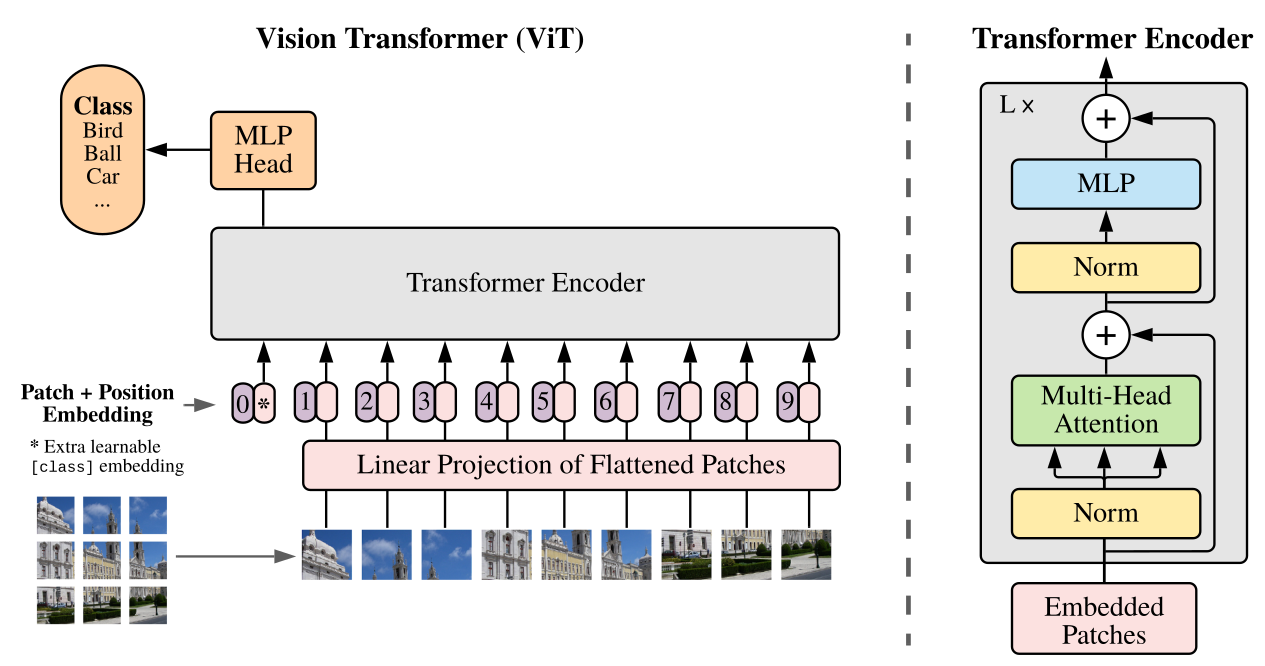

In [1]:
!!pip install -q ipympl

['\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/516.3 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b30.7/516.3 kB\x1b \x1b660.6 kB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b61.4/516.3 kB\x1b \x1b751.4 kB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b153.6/516.3 kB\x1b \x1b1.4 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━\x1b \x1b368.6/516.3 kB\x1b \x1b2.5 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b516.3/516.3 kB\x1b \x1b2.9 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.6 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/dl_blogs/Vision-Transformer-101")

## Imports

In [ ]:
import torch
import torch.nn as nn

## Constants

We'll be defining some hyperparmeters for the model, (correspond to VIT-small model)

In [ ]:
img_size = 224
patch_size = 16   # image is divided into patches of 16 x16 pixels
num_patches = (img_size // patch_size) * (img_size // patch_size)

# transformer parameters
embed_dim = 384
num_heads = 6
depth = 12

## Vision Transformer Architecture

- Only Encoder from original Transformer paper
- Cover different modules in vision Transformers
    - Patch embedding
    - Cls Token, Positional embedding
    - Layer Normalization
    - Self-Attention
    - MLP Layer
    - Transformer block
    - Putting it together


### Patch Embedding

In [ ]:
class PatchEmbed(nn.Module):
    """ Generate Patches from input image, create embeddings for each patch """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [ ]:
# (Batch size, RGB channels, height, width)
input_data = torch.Tensor(1, 3, img_size, img_size)
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim)
patch_embed_output = patch_embed(input_data)
print(f"Patch embedding output shape = {patch_embed_output.shape}")

Patch embedding output shape = torch.Size([1, 196, 384])


### Cls Token, Position Embedding
- Need a mechanism to inform the model of
    - Embedding class
    - Order of patches
- Positional embeddings can be either
    - Derived from mathematical function (usually involves sines and cosines of input index)
    - Learnt by model (which is current case)
    
- **Need for Classification token?**

In [ ]:
# add class token for each patch
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
cls_token = cls_token.expand(input_data.shape[0], -1, -1)
cls_token_output = torch.cat((cls_token, patch_embed_output), dim=1)
print(f"Class token output shape = {cls_token_output.shape}")

Class token output shape = torch.Size([1, 197, 384])


**Note the usage of nn.Parameter, and not something like nn.Linear**

In [ ]:
# add positional encoding to each token
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

# To align with original architecture, we need to add
# dropout on the position embedding. For now, we'll define
# dropout probability as 0
pos_drop = nn.Dropout(p=0)

pos_embed_output = cls_token_output + pos_drop(pos_embed)
print(f"Position Embedding output shape = {pos_embed_output.shape}")

Position Embedding output shape = torch.Size([1, 197, 384])


### Self-Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop, proj_drop):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x) # (1, 197, 3 * 384), contains query, key and values
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)  # (1, 197, 3, 6, 64)

        # (qkv, batch_size, num_heads, num_tokens, dim_per_head)
        qkv =qkv.permute(2, 0, 3, 1, 4)  # (3, 1, 6, 197, 64)

        # query, key, values all are of (1,6,197,64) shape
        q, k, v = qkv[0], qkv[1], qkv[2]

        # query (1,6,197,64) * key (1,6,64, 197) = (1,6,197,197)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # attn (1,6,197,197) * value (1,6,197,64) = (1,6,197,64)
        x = (attn @ v)

        # (1,6,197,64) -> (1,197,6,64) -> (1,197,384)
        x = x.transpose(1, 2).reshape(B, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

In [ ]:
attention_module = Attention(dim = embed_dim, num_heads = num_heads, attn_drop =0.0, proj_drop =0.0 )
attn_output, attn = attention_module(pos_embed_output)
print(f"Attention output shape = {attn_output.shape}")
print(f"Attention shape = {attn.shape}")

Attention output shape = torch.Size([1, 197, 384])
Attention shape = torch.Size([1, 6, 197, 197])


### MLP module

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.drop = nn.Dropout(0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Transformer block

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, attn_drop=0, proj_drop=0)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_dim=dim, hid_dim=mlp_hidden_dim, out_dim=dim)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x, attn

In [ ]:
transformer_block = Block(dim=embed_dim, num_heads=3, mlp_ratio=4)
transformer_block_output, _ = transformer_block(pos_embed_output)
print(f"Transformer block output shape = {transformer_block_output.shape}")

Transformer block output shape = torch.Size([1, 197, 384])


### Putting it altogether

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=0.0)

        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio)
            for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)


    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.pos_embed
        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            x, attn_map = blk(x)
        x = self.norm(x)
        return x, attn_map

In [ ]:
vit = VisionTransformer(img_size=img_size, patch_size=patch_size, in_chans=3,
                        embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=4)

vit_output, attn_map = vit(input_data)
vit_output.shape, attn_map.shape

(torch.Size([1, 197, 384]), torch.Size([1, 6, 197, 197]))

## Visualize Attention

We'll load a pretrained model, and visualized the output on sample images

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load pretrained model
checkpoint = torch.load('vit_small_16_dino_backbone.pth')
vit.load_state_dict(checkpoint)
vit.eval();
vit.to(device);

In [ ]:
import cv2

def preprocess_image(image_path, tf, patch_size):
    # read image -> convert to RGB -> torch Tensor
    rgb_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img = tf(rgb_img)
    _, image_height, image_width = img.shape

    # make the image divisible by the patch size
    w, h = image_width - image_width % patch_size, image_height - image_height % patch_size
    img = img[:, :h, :w].unsqueeze(0)

    w_featmap = img.shape[-1] // patch_size
    h_featmap = img.shape[-2] // patch_size
    return rgb_img, img, w_featmap, h_featmap

In [ ]:
from torchvision import transforms as pth_transforms
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Resize([224, 224]),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [ ]:
test_img_path = '00009.jpg'
rgb_img, img, w_featmap, h_featmap = preprocess_image(test_img_path, patch_size=patch_size, tf=transform)
scaled_rgb_image = cv2.resize(rgb_img, (224, 224), interpolation = cv2.INTER_LINEAR)
print(f"rgb_img shape = {rgb_img.shape}, img shape = {img.shape}")

rgb_img shape = (480, 854, 3), img shape = torch.Size([1, 3, 224, 224])


In [ ]:
# get last stage attention
with torch.no_grad():
    img = img.to(device)
    _, attentions = vit(img)

# nh = number of heads
nh = attentions.shape[1]
print(f"Attentions shape = {attentions.shape}")

Attentions shape = torch.Size([1, 6, 197, 197])


We'll visualize attention maps from different heads for a single pixel

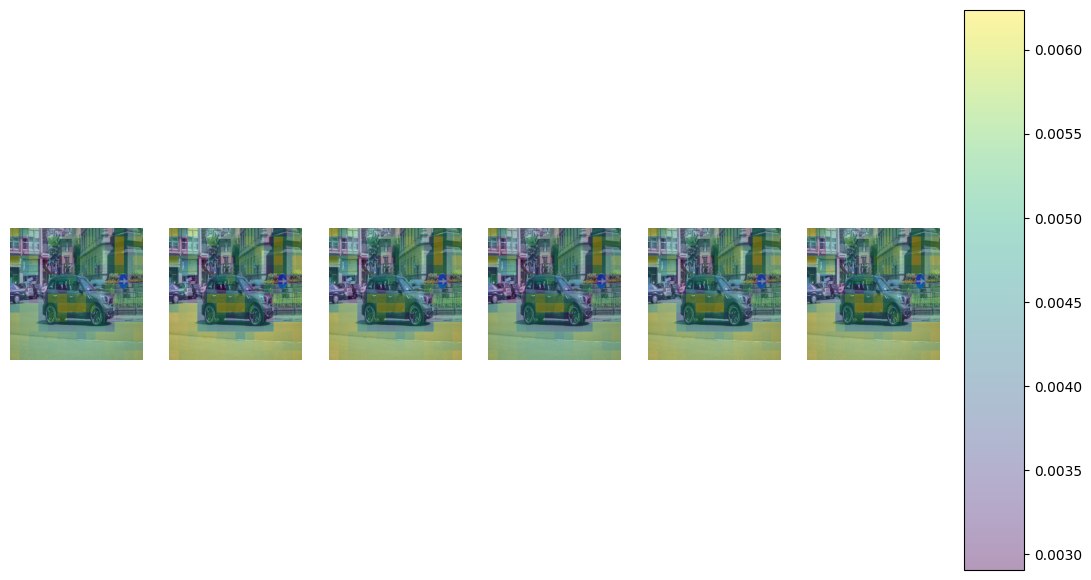

In [ ]:
sample_attention = attentions[0, :, 0, 1:].reshape(nh, w_featmap, h_featmap)
sample_attention = nn.functional.interpolate(sample_attention.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(12,8))
for i in range(6):
    axes[i].imshow(scaled_rgb_image)
    im = axes[i].imshow(sample_attention[i], alpha=0.4)
    axes[i].axis('off')

# add colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


We'll visualize the attention maps from specific pixels

In [ ]:
# for interactive widgets
import numpy as np
import IPython.display as Disp
from ipywidgets import widgets
from google.colab import output
output.enable_custom_widget_manager()

class roi_select():
    def __init__(self,im, figsize=(12,6), line_color=(255,0,0)):
        # class variables
        self.im = im
        self.selected_points = []
        self.line_color = line_color

        # plot input image, store figure handles
        self.fig,ax = plt.subplots(figsize=figsize)
        self.img = ax.imshow(self.im.copy())
        plt.suptitle('Select Rectangular ROI')

        # connect event handlers
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)

    def draw_roi_on_img(self,img,pts):
        # plot polygon edges in single color
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,2))
        # cv2.polylines(img, [pts], True, self.line_color, 5)
        cv2.rectangle(img, pts[0], pts[1], self.line_color, 5)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points) == 2:
            self.img.set_data(self.draw_roi_on_img(self.im.copy(),self.selected_points))
            self.disconnect_mpl(None)

    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)


    def get_bbox_indices(self, scale_factor = None):
        pts = np.array(self.selected_points)
        if(scale_factor is not None):
            pts = pts * scale_factor

        # bounding box coordinates as indices
        # min_x, min_y is top left index
        # max_x, max_y is bottom right index
        roi_indices = pts.astype(int)
        indices = {}
        indices['min_x'], indices['min_y'] = np.min(roi_indices, axis=0)
        indices['max_x'], indices['max_y'] = np.max(roi_indices, axis=0)
        return indices

Button(description='Disconnect mpl', style=ButtonStyle())

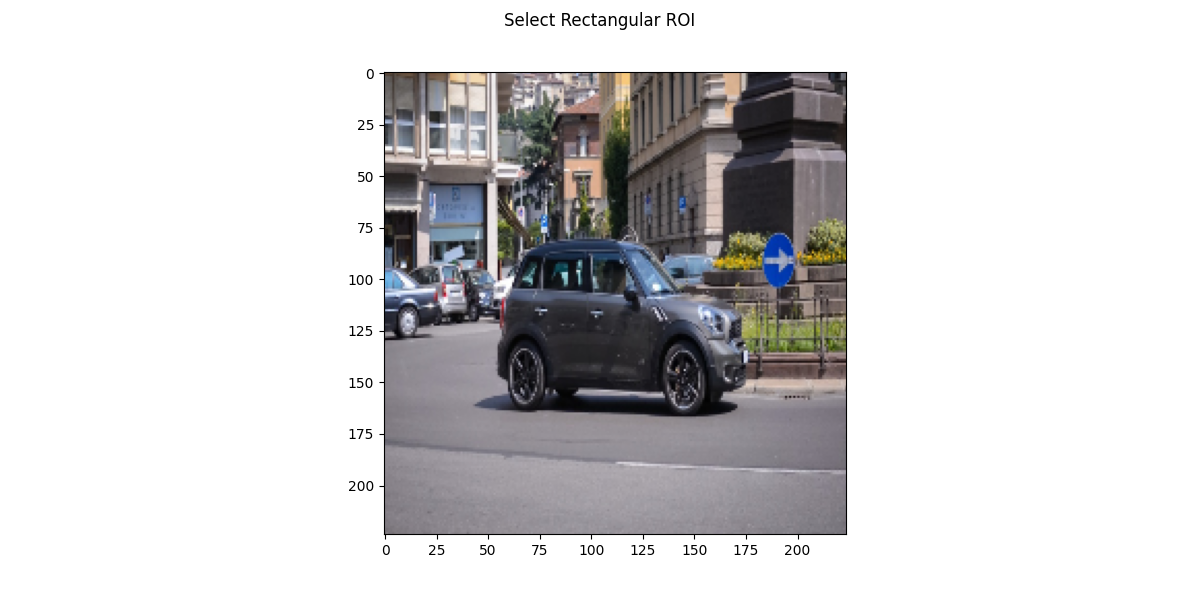

In [ ]:
%matplotlib ipympl
bs = roi_select(scaled_rgb_image)

In [ ]:
def plot_channels(image, num_rows, num_cols, figsize, figTitle, save_plot=False, cmap=None):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if(num_rows * num_cols == 1):
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(len(axes)):
        if(i < image.shape[0]):
            im = axes[i].imshow(image[i], cmap=cmap)
        axes[i].axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(figTitle);

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        fig.savefig(f"{figTitle}.png")

## References